## GMM for clustering
In this question, you are required to implement the expectation-maximization algorithm from scratch to fit a GMM to dataset, and use the mixture for clustering. You are only allowed to use numpy, pandas, matplotlib, etc. and not any preimplemented model at all. <br>

__1:__ Define a function that performs the E-step. That is, given the number of clusters K, the datapoints x, a list of the mean vectors, covariance matrices and prior probabilities, calculates the posterior probability of each point belonging to a cluster. You should try to avoid 'for' loops, especially over the dataset dimenstion D. <br>
__2:__ Define a function that performs the M-step. That is, given the pesterior probability matrix and other necessary inputs, updates the means, covariance matrices and prior probabilites. <br>
__3: (Bonus)__ Implement a function that calculates the log loss (ELBO) over the latent variables and define a convergence criterion this way. Whether you implement this function or not, it is best thaat your algorithm stops after a given amount of iterations. <br>
__4:__ Define a function that initializes the cluster means, covariance matrices and prior probabilties having two options. For choosing the cluster centers, one way must be a random selection of the input datapoints and the other way must be kmeans++. You are clearly allowed to split the logic in few functions or not. <br>
__Note on part 4 for easier implementaion:__ You are allowed to use the following simplification: In kmeans++, for choosing the $1<\ell$th cluster center, a minimum distance metric is calculated for other datapoints, and each datapoint that has not been selected, has a selection probability proportional to its metic value. You can use the argmax of the distribution in each iteration, that is, choose the point with max(min(distance)). <br>

__5:__ Load the two datasets and plot them in separate scatterplots with different colors for each label. Next, forget about the labels and assume a fully unsupervised problem. Fit the GMM and perform your clustering with both initialization methods on both datasets. Plot the datapoints with the new cluster labels (mandatory), and report the log losses (part 3 bonus). <br>
__6: (Theoretical question only)__ Comment on your results. What is the difference between a random sampling and kmeans++ initialization? You can consult the GMM documentation of scikit-learn on initialization to get more clues.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<font color='green'> <h2> E-step </h2> </font>

In this step, the algorithm computes the posterior probabilities (responsibilities) for each data point belonging to each cluster. The code calculates the likelihoods using the Gaussian distribution formula, considering the mean, covariance, and prior probability of each cluster. The likelihoods are then normalized to obtain the posterior probabilities. These probabilities indicate the likelihood of data point assignments to each cluster and are crucial for the subsequent M-step in the GMM clustering algorithm.

In [2]:
# E-step
def e_step(X, means, covariances, priors):
    n_samples = X.shape[0]
    n_clusters = len(means)

    likelihoods = np.zeros((n_samples, n_clusters))

    for k in range(n_clusters):
        mean = means[k]
        covariance = covariances[k]
        prior = priors[k]

        inv_cov = np.linalg.inv(covariance)
        det_cov = np.linalg.det(covariance)
        coef = 1.0 / (np.sqrt((2 * np.pi) ** X.shape[1] * det_cov))

        diff = X - mean
        exponent = -0.5 * np.sum(np.dot(diff, inv_cov) * diff, axis=1)

        likelihoods[:, k] = coef * np.exp(exponent) * prior

    posteriors = likelihoods / np.sum(likelihoods, axis=1, keepdims=True)
    return posteriors


<font color='green'> <h2> M-step </h2> </font>

In this step, the algorithm updates the estimates of cluster means, covariances, and priors based on the posterior probabilities obtained from the E-step. The code iterates over each cluster and calculates the updated mean by taking the weighted average of the data points. It then computes the updated covariance matrix based on the differences between the data points and the updated mean, using the posterior probabilities as weights. The prior probability of each cluster is updated by dividing the total posterior probability by the total number of data points. The updated means, covariances, and priors are returned for further iterations of the GMM clustering algorithm.

In [3]:
# M-step
def m_step(X, posteriors):
    n_samples, n_features = X.shape
    n_clusters = posteriors.shape[1]

    means = np.zeros((n_clusters, n_features))
    covariances = np.zeros((n_clusters, n_features, n_features))
    priors = np.zeros(n_clusters)

    for k in range(n_clusters):
        posterior = posteriors[:, k]
        total_posterior = np.sum(posterior)

        means[k] = np.sum(X * posterior[:, np.newaxis], axis=0) / total_posterior

        diff = X - means[k]
        covariances[k] = np.dot(diff.T, diff * posterior[:, np.newaxis]) / total_posterior

        priors[k] = total_posterior / n_samples

    return means, covariances, priors


<font color='green'> <h2> Loh loss </h2> </font>

This code calculates the log likelihood and the Evidence Lower Bound (ELBO) in the Gaussian Mixture Model (GMM) clustering algorithm. It computes the likelihood of each data point belonging to each cluster using the Gaussian distribution formula. The log likelihoods are then summed and multiplied by the posterior probabilities to obtain the ELBO. The ELBO serves as an objective function to optimize the GMM parameters.

In [4]:
def log_loss(X, means, covariances, priors, posteriors):
    n_samples, _ = X.shape
    n_clusters = means.shape[0]

    likelihoods = np.zeros((n_samples, n_clusters))

    for k in range(n_clusters):
        coef = 1.0 / np.sqrt(np.linalg.det(covariances[k]) * (2 * np.pi) ** means.shape[1])
        diff = X - means[k]
        exponent = -0.5 * np.sum(diff @ np.linalg.inv(covariances[k]) * diff, axis=1)
        prior = priors[k]
        likelihoods[:, k] = coef * np.exp(exponent) * prior

    log_likelihoods = np.log(np.sum(likelihoods, axis=1))
    elbo = np.sum(log_likelihoods * np.transpose(posteriors))

    return elbo

<font color='green'> <h2> Initialize clusters </h2> </font>

It offers two initialization methods: 'random' and 'kmeans++'. In the 'random' method, the initial means are randomly selected from the data points. In the 'kmeans++' method, the means are chosen iteratively based on the distances and probabilities calculated from already chosen means. The covariances are initialized as identity matrices, and the priors are set to equal probabilities. The function returns the initial estimates of means, covariances, and priors for further steps in the GMM clustering algorithm.

In [5]:
# Initialization
def initialize_clusters(X, n_clusters, method='random'):
    if method == 'random':
        indices = np.random.choice(X.shape[0], n_clusters, replace=False)
        means = X[indices]
    elif method == 'kmeans++':
        means = [X[np.random.randint(X.shape[0])]]

        for _ in range(1, n_clusters):
            distances = np.array([min(np.linalg.norm(x - m) for m in means) for x in X])
            probabilities = distances / np.sum(distances)
            next_mean = X[np.argmax(probabilities)]
            means.append(next_mean)

    covariances = [np.eye(X.shape[1])] * n_clusters
    priors = np.ones(n_clusters) / n_clusters

    return means, covariances, priors


In [6]:
# Load datasets and plot
def load_data_and_plot():
    data1 = pd.read_csv('Image1.csv')
    data2 = pd.read_csv('Image2.csv')

    plt.figure
    plt.scatter(data1['0'], data1['1'], label='Data 1')
    plt.scatter(data2['0'], data2['1'], label='Data 2')
    plt.legend()
    plt.show()

    X1 = data1[['0', '1']].values
    X2 = data2[['0', '1']].values

    return X1, X2


<font color='green'> <h2> GMM </h2> </font>

The provided code implements the Gaussian Mixture Model (GMM) clustering algorithm. It iteratively performs the E-step, M-step, and log loss calculations until convergence or the maximum number of iterations. The algorithm initializes cluster parameters, updates them based on the data, and calculates the log loss (ELBO) to monitor convergence. The function returns the posterior probabilities and the final estimates of means, covariances, and priors for the identified clusters.

In [7]:
def gmm_clustering(X, n_clusters, initialization='random', max_iterations=100, tol=1e-4):
    means, covariances, priors = initialize_clusters(X, n_clusters, method=initialization)
    prev_log_loss = None

    for iteration in range(max_iterations):
        # E-step
        posteriors = e_step(X, means, covariances, priors)

        # M-step
        new_means, new_covariances, new_priors = m_step(X, posteriors)

        # Calculate log loss (ELBO)
        log_loss_value = log_loss(X, new_means, new_covariances, new_priors, posteriors)

        # Check convergence
        if prev_log_loss is not None and np.abs(log_loss_value - prev_log_loss) < tol:
            break

        prev_log_loss = log_loss_value

        # Update parameters
        means = new_means
        covariances = new_covariances
        priors = new_priors

    return posteriors, means, covariances, priors

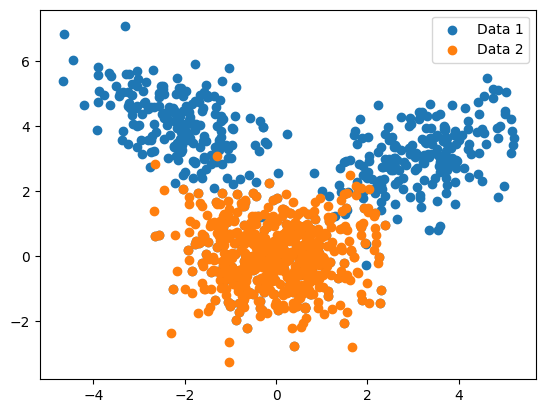

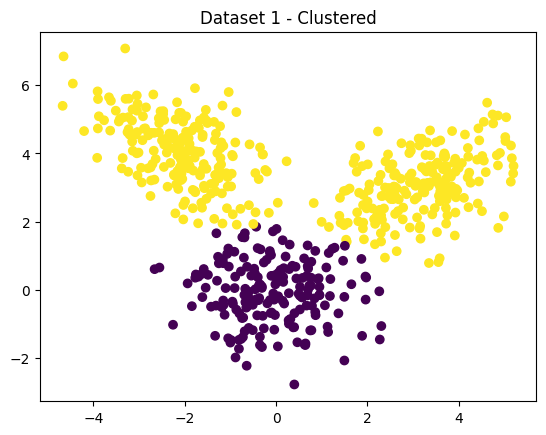

In [8]:
# Load datasets and plot
X1, X2 = load_data_and_plot()

# GMM clustering for dataset 1
n_clusters = 2
posteriors1, means1, covariances1, priors1 = gmm_clustering(X1, n_clusters, initialization='random')

# Plot clustered datapoints for dataset 1
plt.scatter(X1[:, 0], X1[:, 1], c=np.argmax(posteriors1, axis=1))
plt.title('Dataset 1 - Clustered')
plt.show()


<font color="aqua">
It can be seen that our clustering method of GMM, has perfectly clustered and detected data corresponding to dataset 1 and 2 as the results of the clustering (not considering the labels) are quite the same is the figure we have visualized regarding the known labels.
</font>